## 機器學習百日馬拉松期末考——貓狗圖像分類競賽

#### Overview

貓與狗一直都是人類最重要的夥伴，無論你是狗派還是貓派，為自己訓練一個 CNN 模型來分辨貓狗吧！貓狗辨識之前是在 Kaggle 上熱門的競賽之一，非常適合剛學習完卷積神經網路的同學做練習。在本次的期末考，同學會需要應用這一百日中所學到的機器學習知識，來完成這項挑戰！

關鍵問題：

如果你是第一次實作機器學習專案，一開始可能會有些迷惘，不曉得該從何著手，我們提供了一系列的問題，這些都是一個機器學習專案中必須要回答的問題，可以試著從回答以下的問題開始！

- 影像的數量與類別為何？影像的尺寸都一致嗎？是否需要縮放？
- 資料中有沒有可能存在一些噪音？該如何找出這些噪音？
- 影像送進網路前是否需要進行前處理？該怎麼做？
- 神經網路該怎麼搭建，有什麼需要調整的超參數？
- 超參數調整的步驟為何？
- 如何進行訓練集/測試集的切分來驗證模型的結果？

專案結束後你可以學會：

- 如何處理存在各種缺陷的真實資料
- 使用 val/test data 來了解機器學習模型的訓練情形
- 使用適當的評估函數了解預測結果
- 應用適當的特徵工程提升模型的準確率
- 調整機器學習模型的超參數來提升準確率
- 清楚的說明文件讓別人了解你的成果

#### Evaluation

評估指標為 AUC，請參考 Data 中的 submission.csv，將測試資料的預測結果上傳。

非常重要：

請把貓的類別視為 1，狗的類別視為 0，也就是說假設影像是 \[貓, 貓, 狗, 貓, 狗\], 類別標註就會是 \[1, 1, 0, 1, 0\]，請用 \[1, 1, 0, 1, 0\] 這個 list 去做 one-hot encoding，最後上傳答案時，請上傳預測為「貓」的機率值喔！也就是使用：
```
y_pred = model.predict(image)[:, 1]
```
注意只能有兩個 column，且欄位名稱要完全相同(粗體字)，分別為 ID(影像編號：001, 002, ..., 400)、Predicted(預測機率值)，上傳後系統會自動幫您計算 AUC 分數並進行排名。本次期中考 Public score 就是最終結果，請至少超過 baseline 來完成這次的考試。

#### Reference

[ml100marathon-02-02: Final exam for ML 100 marathon by Cupoy](https://www.kaggle.com/c/ml-marathon-final/overview)

[ml100marathon-02-02: Baseline example](https://www.kaggle.com/lcc1106/cats-dogs-classification)

## 準備資料

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import utils, backend
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.1.0


In [2]:
data_path = './data/part08'
data_path_test = f'{data_path}/catdogs/test'
data_path_train = f'{data_path}/catdogs/train'
model_path_train = f'{data_path}/catdogs_model.h5'
ndarray_path_X_train = f'{data_path}/catdogs_x_train.npy'
ndarray_path_y_train = f'{data_path}/catdogs_y_train.npy'
ndarray_path_X_test = f'{data_path}/catdogs_x_test.npy'
ndarray_path_X_test_name = f'{data_path}/catdogs_x_test_name.npy'
csv_path_sample = f'{data_path}/catdogs_sample_submission.csv'
csv_path_result = f'./output/Day_101-103_CatDogs_Final_Exam.csv'

image_sizes = (224, 224,)
image_label_dict = {'dogs': 0, 'cats': 1}

### 1. 讀取圖片檔(執行一次即可)

In [3]:
def make_test_data(data_path, image_sizes):
    X_test = np.empty([0, *image_sizes, 3])
    X_test_name = np.empty([0], dtype='object')
    for file_name in tqdm(os.listdir(data_path)):
        image = imread(f'{data_path}/{file_name}')
        image = resize(image, image_sizes, anti_aliasing=True)[np.newaxis, :, :, :]
        X_test = np.concatenate((X_test, image,), axis=0)
        X_test_name = np.append(X_test_name, file_name.rstrip('.jpg'))
    return X_test, X_test_name

def make_train_data(data_path, image_sizes, label_dict):
    X_train = np.empty([0, *image_sizes, 3])
    y_train = np.empty([0])
    for image_name in os.listdir(data_path):
        image_path = f'{data_path}/{image_name}'
        image_label = label_dict[image_name]
        for file_name in tqdm(os.listdir(image_path)):
            image = imread(f'{image_path}/{file_name}')
            image = resize(image, image_sizes, anti_aliasing=True)[np.newaxis, :, :, :]
            X_train = np.concatenate((X_train, image,), axis=0)
            y_train = np.concatenate((y_train, [image_label],), axis=0)
    return X_train, y_train

In [4]:
X_train, y_train = make_train_data(data_path_train, image_sizes, image_label_dict)
np.save(ndarray_path_X_train, X_train)
np.save(ndarray_path_y_train, y_train)

In [5]:
X_test, X_test_name = make_test_data(data_path_test, image_sizes)
np.save(ndarray_path_X_test, X_test)
np.save(ndarray_path_X_test_name, X_test_name)

### 2. 讀取正規化後的圖片陣列並標準化資料

In [6]:
def normalize_data(x, y):
    x = ((x - np.mean(x)) / np.std(x)).astype('float32')
    y = utils.to_categorical(y, num_classes=np.unique(y).size)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [7]:
X_train, y_train = np.load(ndarray_path_X_train), np.load(ndarray_path_y_train)
X_test, X_test_name = np.load(ndarray_path_X_test), np.load(ndarray_path_X_test_name, allow_pickle=True)

In [8]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (4000, 224, 224, 3)
y.shape: (4000,)


In [9]:
print('After normalization:')
X_test, _ = normalize_data(X_test, X_test_name)
X_train, y_train = normalize_data(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.25, random_state=42)
normalize_result(X_train, y_train)

After normalization:
x.shape: (3000, 224, 224, 3)
y.shape: (3000, 2)


## 定義函數

In [10]:
def image_generator(x, y, batch_size=32, shuffle=True):
    generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
    return generator.flow(x, y, batch_size=batch_size, shuffle=shuffle)

class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, checkpoint_path, epochs=50, batch_size=4, learning_rate=1e-5):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.checkpoint_path = checkpoint_path
        self._model = None
        self._score = None
        self._history = None

    @property
    def optimizer(self):
        return Adam(lr=self.learning_rate)

    @property
    def callbacks(self):
        checkpoint = ModelCheckpoint(self.checkpoint_path, save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
        reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.5, min_lr=1e-12, verbose=1)
        return [checkpoint, early_stopping, reduce_lr_on_plateau]

    @property
    def test_generator(self):
        return image_generator(self.X_test, self.y_test, batch_size=self.batch_size, shuffle=False)

    @property
    def train_generator(self):
        return image_generator(self.X_train, self.y_train, batch_size=self.batch_size, shuffle=False)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        if os.path.isfile(self.checkpoint_path):
            self._model = load_model(self.checkpoint_path)
        else:
            resnet = ResNet50(input_shape=self.X_train.shape[1:], include_top=False)
            inputs = resnet.input
            outputs = resnet.output
            outputs = Flatten()(outputs)
            outputs = Dropout(0.5)(outputs)
            outputs = Dense(np.unique(self.y_test).size, name='softmax', activation='softmax')(outputs)
            self._model = Model(inputs=inputs, outputs=outputs)
            self._model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with ResNet50.')
        self._model.summary()
        self._history = self._model.fit(
            self.train_generator, steps_per_epoch=self.X_train.shape[0] // self.batch_size,
            validation_data=self.test_generator, validation_steps=self.X_test.shape[0] // self.batch_size,
            epochs=self.epochs, callbacks=self.callbacks, shuffle=True, verbose=1)
        return self

    def predict(self, test_data):
        test_pred = self._model.predict(test_data)
        return test_pred

    def display(self, train_name, val_name):
        plt.figure(figsize=(8, 6,))
        plt.plot(self._history.history[train_name])
        plt.plot(self._history.history[val_name])
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    def display_roc(self):
        y_true = np.argmax(self.y_test, axis=1)
        y_pred = np.argmax(self.predict(self.X_test), axis=1)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6,))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc='lower right')
        plt.show()

## 訓練模型

In [11]:
trainer = Trainer(X_train, y_train, X_val, y_val, model_path_train).run()

Experiment with ResNet50.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________

  ...
    to  
  ['...']
Train for 750 steps, validate for 250 steps
Epoch 1/50
750/750 [==============================] - 50s 66ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0769 - val_accuracy: 0.9820
Epoch 2/50
750/750 [==============================] - 43s 57ms/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 0.0991 - val_accuracy: 0.9770
Epoch 3/50
750/750 [==============================] - 43s 57ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0991 - val_accuracy: 0.9810
Epoch 4/50
750/750 [==============================] - 43s 57ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0839 - val_accuracy: 0.9810
Epoch 5/50
750/750 [==============================] - 43s 57ms/step - loss: 4.9300e-04 - accuracy: 1.0000 - val_loss: 0.0568 - val_accuracy: 0.9870
Epoch 6/50
750/750 [==============================] - 42s 56ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0862 - val_accuracy: 0.9810
Epoch 7/50
750/750 [==============================] - 42s 57ms/

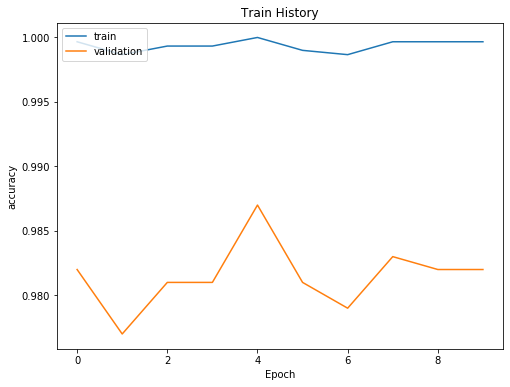

In [12]:
trainer.display('accuracy', 'val_accuracy')

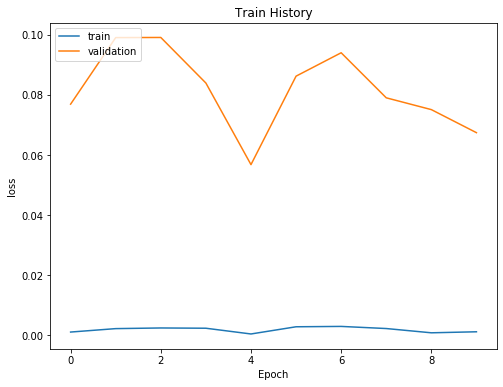

In [13]:
trainer.display('loss', 'val_loss')

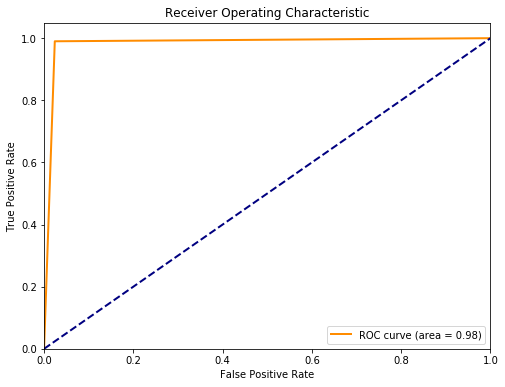

In [14]:
trainer.display_roc()

## 輸出結果

In [15]:
def make_output(X_name, y_pred, src_path, dst_path):
    df = pd.read_csv(src_path)
    df['ID'] = X_name
    df['Predicted'] = y_pred[:, 1]
    df = df[['ID', 'Predicted']]
    df = df.sort_values(by=['ID'])
    df.to_csv(dst_path, header=['ID', 'Predicted'], index=False)
    df.head(10)

In [16]:
y_test_pred = trainer.predict(X_test)
make_output(X_test_name, y_test_pred, csv_path_sample, csv_path_result)